<a href="https://colab.research.google.com/github/joanby/trading-algoritmico-analisis-tecnico/blob/main/ES_TA_Cap%C3%ADtulo_05_Backtesting_Vectorizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px">
<img alt="Colaboratory logo" height="45px" src="https://static-881c.kxcdn.com/wp-content/uploads/2016/03/frogamesLogoFull4.png" align="left" hspace="10px" vspace="0px"></p>

# BackTesting Vectorizado
El backtesting es una parte esencial del trading. En efecto, es importante comprender el comportamiento de nuestra estrategia en el pasado para poder considerar los del futuro.

### Contenido

* Sortino Beta Alpha
* Drawdown 
* Crear la funci√≥n BackTest para evaluar la estrategia en las secciones posteriores

</br>


üí∞ √önete a la comunidad de [Discord](https://discord.gg/wXjNPAc5BH)

üìö Puedes leer nuestro libro en [Amazon](https://www.amazon.com/gp/product/B09HG18CYL)

üñ•Ô∏è El canal de [YouTube de Quantreo's](https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw) (en ingl√©s) y el de [Frogames](https://www.youtube.com/channel/UCMUxXNYrVCv6-bQakhomvBg) en espa√±ol

### Entorno

In [1]:
%pip install yfinance    
%pip install ta

  Using cached yfinance-0.1.74-py2.py3-none-any.whl (27 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached urllib3-1.26.12-py2.py3-none-any.whl (140 kB)
  Using cached idna-3.4-py3-none-any.whl (61 kB)
  Using cached charset_normalizer-2.1.1-py3-none-any.whl (39 kB)
  Using cached certifi-2022.9.14-py3-none-any.whl (162 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached ta-0.10.2-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import ta
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

### Funci√≥n

In [ ]:
def RSI(val, neutral, window):
  """ 
        ------------------------------------------------------------------------------
        | Output: La funci√≥n da los rendimientos de la estrategia RSI                |
        ------------------------------------------------------------------------------
        | Inputs: -val (type dataframe pandas): Valores de entrada de la acci√≥n      |
        |         -neutral (float): Valor neutral, es decir, zona de no acci√≥n       |
        |         -window (float): per√≠odo de balanceo para el RSI                   |
        ------------------------------------------------------------------------------
  """

  # Print Error if there is no column Adj Close in the dataframe
  if "Adj Close" not in val.columns:
    ValueError("Necesitamos tener un nombre de columna Adj Close porque todos los c√°lculos se refieren a esta columna")
  
  val["rsi"] = ta.momentum.RSIIndicator(val["Adj Close"], window=window).rsi()


  
  """Se√±al de compra en largo """
  # Colocamos el umbral
  overbuy = 70
  neutral_buy = 50 + neutral

  # Poner valores nan para las columnas de la se√±al larga
  val["signal_long"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # Necesitamos definir la se√±al de apertura en largo (RSI ayer<55 y RSI hoy>55)
  val.loc[(val["rsi"]>neutral_buy) & (val["yersteday_rsi"]<neutral_buy), "signal_long"] = 1

  # Necesitamos definir la se√±al cierre en largo (RSI ayer>55 y RSI hoy<55) Se√±al falsa
  val.loc[(val["rsi"]<neutral_buy)&(val["yersteday_rsi"]>neutral_buy), "signal_long"] = 0

  # Necesitamos definir la se√±al cierre en largo (RSI ayer<70 y RSI hoy>70) Se√±al de sobrecompra
  val.loc[(val["rsi"]>overbuy)&(val["yersteday_rsi"]<overbuy), "signal_long"] = 0



  """Se√±al de venta en corto """
  # Colocamos el umbral
  oversell = 30
  neutral_sell = 50 - neutral

  # Poner valores nan para las columnas de la se√±al larga
  val["signal_short"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # Necesitamos definir la se√±al de apertura en corto (RSI ayer>45 y RSI hoy<45)
  val.loc[(val["rsi"]<neutral_sell) & (val["yersteday_rsi"]>neutral_sell), "signal_short"] = -1

  # Necesitamos definir la se√±al de cierre en corto (RSI ayer<45 y RSI hoy>45) Se√±al falsa
  val.loc[(val["rsi"]>neutral_sell)&(val["yersteday_rsi"]<neutral_sell), "signal_short"] = 0

  # Necesitamos definir la se√±al de cierre en corto (RSI ayer>30 y RSI hoy<30) Se√±al de sobre venta
  val.loc[(val["rsi"]<oversell)&(val["yersteday_rsi"]>oversell), "signal_short"] = 0

  """Calcular el retorno """
  # Calculamos el porcentaje de variaci√≥n del activo
  val["pct"] = val["Adj Close"].pct_change(1)

  # Calculamos las posiciones
  val["Position"] = (val["signal_short"].fillna(method="ffill")+ val["signal_long"].fillna(method="ffill"))

  # Calculamos el valor de retorno de la estrategia
  val["return"] = val["pct"]*(val["Position"].shift(1))

  return val["return"]

# Secci√≥n 1: Sortino Beta Alpha

###### Sortino
El √≠ndice de Sortino es una estad√≠stica similar al √≠ndice de Sharpe con la misma interpretaci√≥n. Sin embargo, el c√°lculo es ligeramente diferente. En efecto, en el √≠ndice de Sortino s√≥lo se tiene en cuenta la volatilidad de las ganancias negativas porque es lo que tememos y no las ganancias alcistas que nos hacen ganar dinero. <br>
<p align="center">
$Sortino = \frac{\mu }{\sigma_{down}}$
<p> <br>

* SortinoRatio < 0 : Inversi√≥n no rentable porque las ganancias son negativas.
* SortinoRatio < 1: Inversi√≥n rentable, pero el riesgo de la inversi√≥n es mayor que la rentabilidad.
* SortinoRatio > 1: Inversi√≥n muy rentable porque el riesgo es menor que el rendimiento.


In [ ]:
# Preparar los datos 
f = yf.download("GOOG", end="2021-01-01")
return_serie = RSI(f,5, 14)

# Calcular el √≠ndice de Sortino
mean = np.mean(return_serie) #252
vol = np.std(return_serie[return_serie<0]) #np.sqrt(252)
sortino = np.sqrt(252)*mean/vol

print(f"Sortino: {'%.3f' % sortino}")

[*********************100%***********************]  1 of 1 completed
Sortino: -0.162


###### Beta
La beta es un estad√≠stico que indica la relaci√≥n entre las variaciones de nuestra cartera y las del mercado que est√° representado por un √≠ndice (por ejemplo el SP500). <br>

<p align="center">
$Beta = \frac{Cov(r_{M},r_{PF}) }{Var(r_{M})}$
<p> <br>



* abs(Beta) < 1: Es bueno porque significa que la cartera tiene una variaci√≥n menor que el √≠ndice. (Si beta=0,9 significa que si el √≠ndice var√≠a en 1 la cartera var√≠a en 0,9)
* abs(Beta) > 1: No es bueno porque significa que slau cartera tiene una variaci√≥n mayor que el √≠ndice. (Si beta=1,1 significa que si el √≠ndice var√≠a de 1 la cartera var√≠a en 1,1)

*abs(-x) = x = abs(x) (abs da s√≥lo el valor de la variable no el signo)*

In [ ]:
# Necesitamos calcular la covarianza entre el mercado y la cartera 
sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
sp500.name = "SP500"

# Los concatenamos para hacer las covarianzas
val = pd.concat((return_serie, sp500), axis=1).dropna()
val

[*********************100%***********************]  1 of 1 completed


return     SP500
Date                          
2014-05-22  0.011356  0.002362
2014-05-23  0.014017  0.004248
2014-05-27  0.023973  0.005988
2014-05-28 -0.007545 -0.001114
2014-05-29 -0.002849  0.005367
...              ...       ...
2020-12-24  0.000000  0.003537
2020-12-28  0.000000  0.008723
2020-12-29 -0.009780 -0.002227
2020-12-30 -0.000000  0.001342
2020-12-31  0.000000  0.006439

[1666 rows x 2 columns]

In [ ]:
# Calculamos la matriz de covarianzas
cov_var_mat = np.cov(val.values, rowvar=False)
cov_var_mat

array([[ 1.10851791e-04, -1.03896556e-05],
       [-1.03896556e-05,  1.29870452e-04]])

In [ ]:
# Calculamos beta 
cov = cov_var_mat[0][1]
var = cov_var_mat[1][1]

beta = cov/var

print(f"Beta: {'%.3f' % beta}")

Beta: -0.080


###### **Alpha**
El alfa es una estad√≠stico que indica si la cartera supera al mercado en t√©rminos de rentabilidad del riesgo. <br>

<p align="center">
$Alpha = r_{PF} - \beta*(r_{PF} - r_{f}) - r_{f}$
<p> <br>


* alfa > 0: La cartera supera al mercado en t√©rminos de rentabilidad del riesgo
* alfa < 0: la cartera tiene un rendimiento inferior al del mercado en t√©rminos de riesgo-rendimiento



In [ ]:
# Calculamos alpha 
alpha = (252 * mean * (1-beta))*100
print(f"Alpha: {'%.1f' % alpha} %")

Alpha: -3.1 %


# Secci√≥n 2: Drawdown

El drawdown (reducci√≥n) es una medida del riesgo de la estrategia. Una estad√≠stica interesante para conocer el rendimiento del algoritmo es el drawdown m√°ximo. En efecto, representa la p√©rdida m√°xima de una estrategia durante un per√≠odo de tiempo que nos permite comprender si la estrategia es arriesgada y, por tanto, elegirla en funci√≥n de nuestro nivel de aversi√≥n al riesgo.

In [ ]:
def drawdown_function(serie):

  # Calculamos la suma de los rendimientos
  cum = serie.dropna().cumsum() + 1

  # Calculamos el m√°ximo de la suma en el per√≠odo (m√°ximo acumulado) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  # Calculamos el drawdown
  drawdown = cum/running_max - 1
  return drawdown

In [ ]:
# Calculamos el drawdown
drawdown = drawdown_function(return_serie)
drawdown

Date
2014-05-22    0.000000
2014-05-23    0.000000
2014-05-27    0.000000
2014-05-28   -0.007190
2014-05-29   -0.009905
                ...   
2020-12-24   -0.226287
2020-12-28   -0.226287
2020-12-29   -0.235512
2020-12-30   -0.235512
2020-12-31   -0.235512
Name: return, Length: 1666, dtype: float64

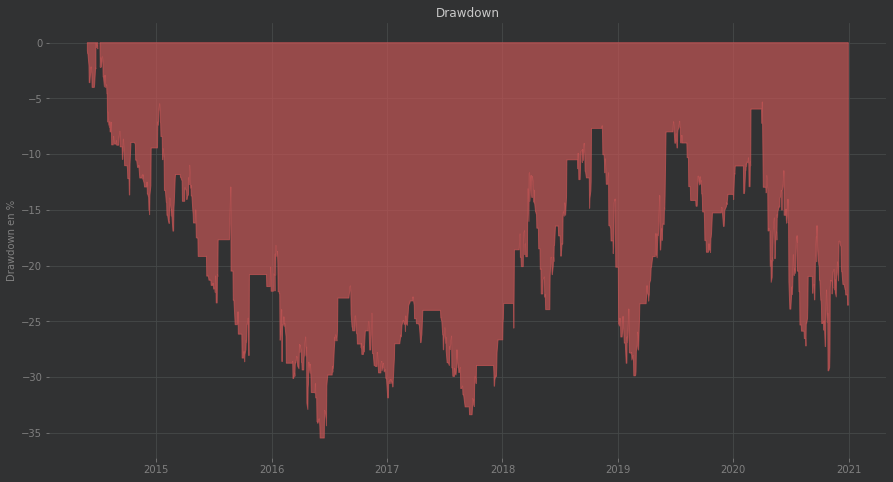

In [ ]:
# Adaptar el tama√±o de la figura
plt.figure(figsize=(15,8))

# Representar el drawdown
plt.fill_between(drawdown.index, drawdown*100, 0,
                 drawdown, color="#CE5757", alpha=0.65)

# A√±adimos el t√≠tulo
plt.title("Drawdown")

# Etiqueta del eje de la y
plt.ylabel("Drawdown en %")

plt.show()


In [ ]:
# C√°lculo del drawdown m√°ximo
max_drawdown = -np.min(drawdown)*100
print(f"Max drawdown: {'%.1f' % max_drawdown} %")

Max drawdown: 35.5 %


# Secci√≥n 3: Crear la funci√≥n BackTest para evaluar la estrategia en las secciones posteriores

In [ ]:
def BackTest(serie, annualiazed_scalar=252):

  # Importar el benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Cambiar el nombre
  sp500.name = "SP500"

  # Concatenar los retornos y el sp500
  val = pd.concat((serie,sp500), axis=1).dropna()
  # Calcular el drawdown
  drawdown = drawdown_function(serie)*100
  
  # Calcular el max drawdown
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown en %", size=11)

  # Plot the graph
  plt.show()


  # Calcular el √≠ndice sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Calcular el √≠ndice  beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Calcular el √≠ndice  alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Imprimir los estad√≠sticos
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

[*********************100%***********************]  1 of 1 completed


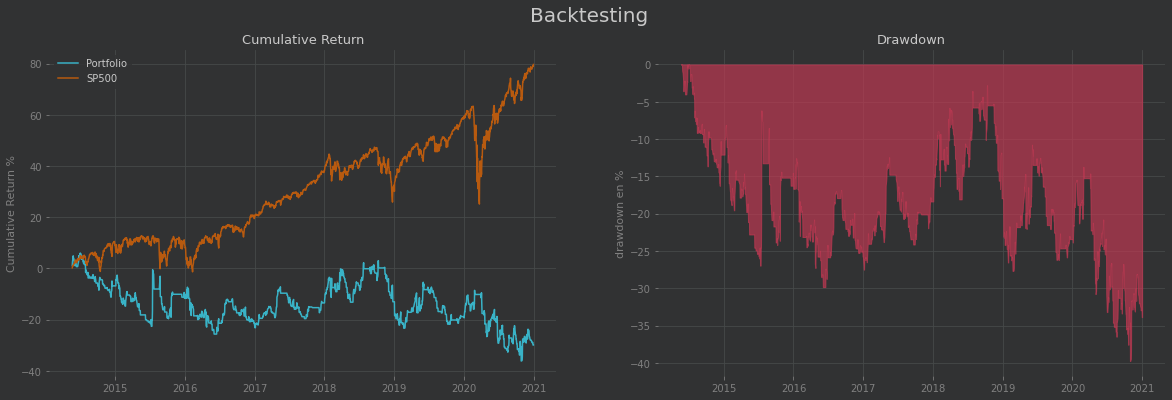

Sortino: -0.249
Beta: -0.069
Alpha: -4.833 %
MaxDrawdown: 39.75 %


In [ ]:
return_serie = RSI(f,5, 14)
BackTest(return_serie, annualiazed_scalar=252)

Sortino: -0.162
Beta: -0.08
Alpha: -3.096 %
MaxDrawdown: 35.466 %
